<a href="https://colab.research.google.com/github/DietzscheNostoevsky/Learning_Pytorch/blob/main/04_Pytorch_Custom_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch Custom Datasets

- A custom dataset is a collection of data relating to a specific problem we are working on.
- Á custom dataset can be comprised of almost anything.

*PyTorch includes many existing functions to load in various custom datasets in the [`TorchVision`](https://pytorch.org/vision/stable/index.html), [`TorchText`](https://pytorch.org/text/stable/index.html), [`TorchAudio`](https://pytorch.org/audio/stable/index.html) and [`TorchRec`](https://pytorch.org/torchrec/) domain libraries.*

But sometimes these existing functions may not be enough.

In that case, we can always subclass `torch.utils.data.Dataset` and customize it to our liking.

# Notebook Workflow 


<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pytorch-food-vision-layout.png" alt="building a pipeline to load in food images and then building a pytorch model to classify those food images" width=800 />

we're going to be using our own dataset of pizza, steak and sushi images.

The goal will be to load these images and then build a model to train and predict on them.

 We'll use `torchvision.datasets` as well as our own custom Dataset class to load in images of food and then we'll build a PyTorch computer vision model to hopefully be able to classify them


# 0. Setting up devive agnostic code

In [5]:
import torch
from torch import nn 

torch.__version__

'2.0.0+cu118'

In [6]:
# Setting up device agnostic code 

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

# 1. Getting data 

Using a subset of food images data from Food101 dataset, which contains 101 food classes, each containing 1000 images per class, total 101,000 images. Each class containing 750 train, 250 test images.  

We are using only random 10% images per class, for 3 classes   
    - Pizza  
    - Steak   
    - Sushi   



## Original Data Source 

Original Data Resources :
* Original [Food101 dataset and paper website](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/).
* [`torchvision.datasets.Food101`](https://pytorch.org/vision/main/generated/torchvision.datasets.Food101.html) - the version of the data downloaded for this notebook.
* [`extras/04_custom_data_creation.ipynb`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb) - a notebook used to format the Food101 dataset to use for this notebook.
* [`data/pizza_steak_sushi.zip`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi.zip) - the zip archive of pizza, steak and sushi images from Food101, created with the notebook linked above.


In [11]:
import requests
import zipfile
from pathlib import Path
from tqdm.auto import tqdm

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    download_url = "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip"
    download_file = data_path / "pizza_steak_sushi.zip"
    
    response = requests.get(download_url, stream=True)
    total_size = int(response.headers.get('content-length', 0))
    progress_bar = tqdm(total=total_size, unit='B', unit_scale=True, desc='Downloading')
    
    with open(download_file, "wb") as f:
        for data in response.iter_content(chunk_size=4096):
            f.write(data)
            progress_bar.update(len(data))
    
    progress_bar.close()
    
    # Unzip pizza, steak, sushi data
    unzip_path = data_path / "pizza_steak_sushi.zip"
    extract_path = image_path
    
    with zipfile.ZipFile(unzip_path, "r") as zip_ref:
        file_list = zip_ref.namelist()
        progress_bar = tqdm(file_list, desc='Extracting')
        
        for file in progress_bar:
            zip_ref.extract(file, extract_path)
        
    progress_bar.close()

    print("Download and extraction complete!")


data/pizza_steak_sushi directory exists.


# 2. Data Prepration

***What Am I trying to solve ?*** 

We have images of pizza, steak and sushi in standard image classification format.

Image classification format contains separate classes of images in seperate directories titled with a particular class name.

For example, all images of `pizza` are contained in the `pizza/` directory.

This format is popular across many different image classification benchmarks, including [ImageNet](https://www.image-net.org/) (of the most popular computer vision benchmark datasets).

The goal will be to **take this data storage structure and turn it into a dataset usable with PyTorch**.

## Setting up directories

In [12]:
# Helper function to see what is inside the directory 
# using os.walk()
import os


def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory
  
  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")


In [13]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.


In [14]:
# Setting up training and testing paths 

train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## Image Visualization

1. Get all of the image paths using [`pathlib.Path.glob()`](https://docs.python.org/3/library/pathlib.html#pathlib.Path.glob) to find all of the files ending in `.jpg`. 
2. Pick a random image path using Python's [`random.choice()`](https://docs.python.org/3/library/random.html#random.choice).
3. Get the image class name using [`pathlib.Path.parent.stem`](https://docs.python.org/3/library/pathlib.html#pathlib.PurePath.parent).
4. And since we're working with images, we'll open the random image path using [`PIL.Image.open()`](https://pillow.readthedocs.io/en/stable/reference/Image.html#PIL.Image.open) (PIL stands for Python Image Library).
5. We'll then show the image and print some metadata.


Random image path: data/pizza_steak_sushi/test/sushi/1680893.jpg
Image class: sushi
Image height: 512
Image width: 512


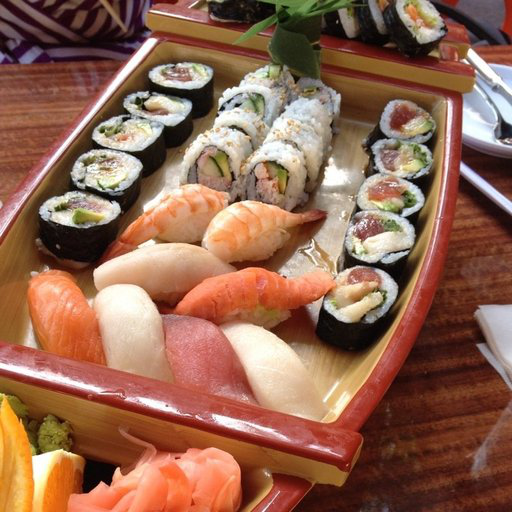

In [20]:
import random
from PIL import Image

random.seed(37)

# Gettting all image paths 
image_path_list = list(image_path.glob("*/*/*.jpg"))

# getting random image path 
random_image_path = random.choice(image_path_list)

# getting image class from path name 

image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img

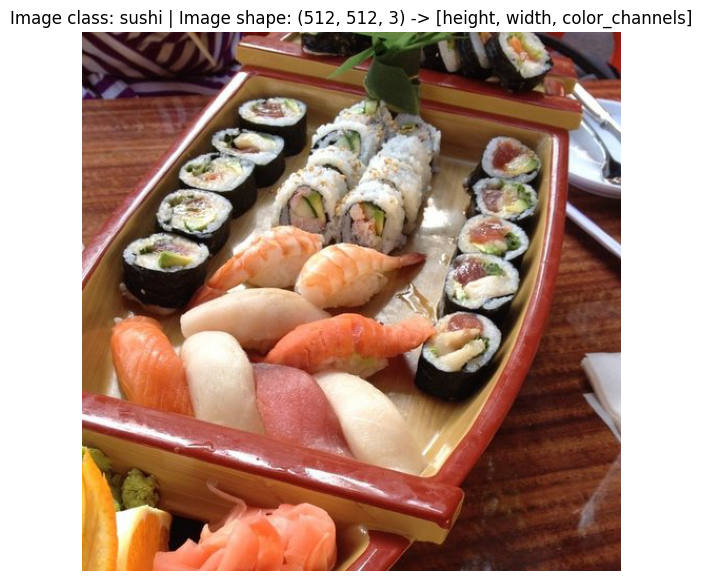

In [21]:
# Using Numpy 
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);